In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import hashlib
from imblearn.over_sampling import RandomOverSampler, SMOTE

### Pre-Processing

In [60]:
data=pd.read_csv('./Data/onlinefraud.csv')

In [61]:
# convert type to number categorical
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,2,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,2,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [62]:
data = data.drop(["nameOrig", "nameDest","step"], axis=1)

In [63]:
# Prepare the Data
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Models

#### DNN

In [27]:
# Build the Dense Neural Network (DNN)
dnn_model = Sequential()
dnn_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(optimizer='adam', loss='binary_crossentropy')
dnn_model.fit(X_train_scaled, y_train, epochs=6, batch_size=32)
dnn_predictions = dnn_model.predict(X_test_scaled)
dnn_predictions = np.round(dnn_predictions)

Epoch 1/6
159066/159066 [==============================] - 122s 764us/step - loss: 0.0037
Epoch 2/6
159066/159066 [==============================] - 126s 795us/step - loss: 0.0029
Epoch 3/6
159066/159066 [==============================] - 119s 747us/step - loss: 0.0027
Epoch 4/6
159066/159066 [==============================] - 117s 736us/step - loss: 0.0029
Epoch 5/6
159066/159066 [==============================] - 122s 765us/step - loss: 0.0027
Epoch 6/6
39767/39767 [==============================] - 20s 498us/step


In [41]:
dnn_predictions = dnn_model.predict(X_test_scaled)
dnn_predictions = np.round(dnn_predictions)

39767/39767 [==============================] - 20s 510us/step


DNN Confusion Matrix:
[[1270780     124]
 [    517    1103]]
DNN Accuracy: 0.9994962766910487
DNN Precision: 0.8989405052974735
DNN Recall: 0.6808641975308642
DNN F1-Score: 0.7748507200561995


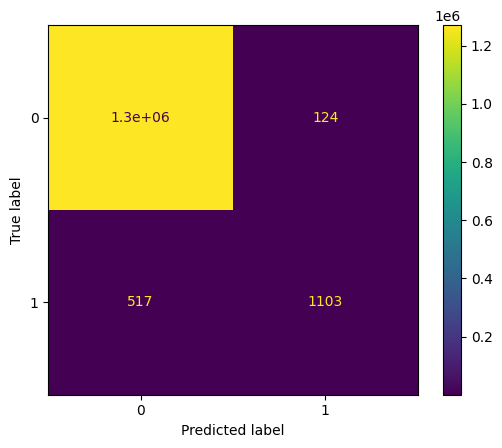

In [42]:
# Calculate Evaluation Metrics
dnn_confusion_matrix = confusion_matrix(y_test, dnn_predictions)
dnn_accuracy = accuracy_score(y_test, dnn_predictions)
dnn_precision = precision_score(y_test, dnn_predictions)
dnn_recall = recall_score(y_test, dnn_predictions)
dnn_f1_score = f1_score(y_test, dnn_predictions)


# Print the results
print("DNN Confusion Matrix:")
print(dnn_confusion_matrix)
print("DNN Accuracy:", dnn_accuracy)
print("DNN Precision:", dnn_precision)
print("DNN Recall:", dnn_recall)
print("DNN F1-Score:", dnn_f1_score)

ConfusionMatrixDisplay(confusion_matrix=dnn_confusion_matrix).plot()


In [43]:
fraud_X_test = X_test_scaled[y_test == 0]
fraud_y_test = y_test[y_test == 0]

dnn_predictions = dnn_model.predict(fraud_X_test)
dnn_predictions = np.round(dnn_predictions)

# Calculate Evaluation Metrics
tn,fp,fn,tp = confusion_matrix(fraud_y_test, dnn_predictions).ravel()
dnn_accuracy = accuracy_score(fraud_y_test, dnn_predictions)
dnn_precision = precision_score(fraud_y_test, dnn_predictions)
dnn_recall = recall_score(fraud_y_test, dnn_predictions)
dnn_f1_score = f1_score(fraud_y_test, dnn_predictions)


# Print the results
print("DNN Confusion Matrix:")
print(tn,fp,fn,tp)
print("DNN Accuracy:", dnn_accuracy)
print("DNN Precision:", dnn_precision)
print("DNN Recall:", dnn_recall)
print("DNN F1-Score:", dnn_f1_score)

39716/39716 [==============================] - 20s 507us/step


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DNN Confusion Matrix:
1270780 124 0 0
DNN Accuracy: 0.999902431654948
DNN Precision: 0.0
DNN Recall: 0.0
DNN F1-Score: 0.0


#### Decision Tree

In [13]:
class_weights = {0: 1, 1: 4}  # Adjust the weights 

# Build the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(class_weight=class_weights)

# Train the Decision Tree Classifier
dt_classifier.fit(X_train_scaled, y_train)

# Make predictions with the Decision Tree Classifier
dt_predictions = dt_classifier.predict(X_test_scaled)

# Calculate evaluation metrics for Decision Tree Classifier
dt_confusion_matrix = confusion_matrix(y_test, dt_predictions)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions)
dt_recall = recall_score(y_test, dt_predictions)
dt_f1_score = f1_score(y_test, dt_predictions)

# Print the results for Decision Tree Classifier
print("Decision Tree Classifier Confusion Matrix:")
print(dt_confusion_matrix)
print("Decision Tree Classifier Accuracy:", dt_accuracy)
print("Decision Tree Classifier Precision:", dt_precision)
print("Decision Tree Classifier Recall:", dt_recall)
print("Decision Tree Classifier F1-Score:", dt_f1_score)

Decision Tree Classifier Confusion Matrix:
[[1270764     140]
 [    218    1402]]
Decision Tree Classifier Accuracy: 0.999718669353191
Decision Tree Classifier Precision: 0.9092088197146563
Decision Tree Classifier Recall: 0.8654320987654321
Decision Tree Classifier F1-Score: 0.8867805186590766


In [14]:

# Build the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(class_weight=class_weights)

# Train the Decision Tree Classifier
dt_classifier.fit(X_train_scaled, y_train)

# Make predictions with the Decision Tree Classifier
dt_predictions = dt_classifier.predict(X_test_scaled)

# Calculate evaluation metrics for Decision Tree Classifier
dt_confusion_matrix = confusion_matrix(y_test, dt_predictions)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions)
dt_recall = recall_score(y_test, dt_predictions)
dt_f1_score = f1_score(y_test, dt_predictions)

# Print the results for Decision Tree Classifier
print("Decision Tree Classifier (without balancing weights) Confusion Matrix:")
print(dt_confusion_matrix)
print("Decision Tree Classifier Accuracy:", dt_accuracy)
print("Decision Tree Classifier Precision:", dt_precision)
print("Decision Tree Classifier Recall:", dt_recall)
print("Decision Tree Classifier F1-Score:", dt_f1_score)

Decision Tree Classifier (without balancing weights) Confusion Matrix:
[[1270768     136]
 [    216    1404]]
Decision Tree Classifier Accuracy: 0.9997233843919643
Decision Tree Classifier Precision: 0.9116883116883117
Decision Tree Classifier Recall: 0.8666666666666667
Decision Tree Classifier F1-Score: 0.8886075949367088


#### Using Grid Sweep to find best parameters for DT


In [66]:
# Define the range of weight ratios to test
weight_ratios = [1.5, 2, 2.5, 3, 3.5]

# Create a parameter grid for the weight ratios
param_grid = {'class_weight': [{0: 1, 1: ratio} for ratio in weight_ratios]}

# Create the decision tree classifier
dt_model = DecisionTreeClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='recall')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best weight ratio and corresponding results
best_weight_ratio = grid_search.best_params_['class_weight']
best_results = grid_search.cv_results_

# Print the results for each weight ratio
for ratio, mean_score, std_score in zip(weight_ratios, best_results['mean_test_score'], best_results['std_test_score']):
    print("Weight Ratio:", ratio)
    print("Mean Recall:", mean_score)
    print("Standard Deviation of Recall:", std_score)
    print()

# Evaluate the model with the best weight ratio on the test set
best_dt_model = grid_search.best_estimator_
y_pred = best_dt_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics for the best model
print("Best Weight Ratio:", best_weight_ratio)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Weight Ratio: 1.5
Mean Recall: 0.8859409747348488
Standard Deviation of Recall: 0.011383266535568828

Weight Ratio: 2
Mean Recall: 0.8827542132553173
Standard Deviation of Recall: 0.0063796695116469125

Weight Ratio: 2.5
Mean Recall: 0.8836651438471919
Standard Deviation of Recall: 0.00968798606540316

Weight Ratio: 3
Mean Recall: 0.8826051142344697
Standard Deviation of Recall: 0.010434012343694465

Weight Ratio: 3.5
Mean Recall: 0.8824537143028067
Standard Deviation of Recall: 0.012131161548053684

Best Weight Ratio: {0: 1, 1: 1.5}
Accuracy: 0.999754032143991
Precision: 0.909717868338558
Recall: 0.895679012345679
F1-Score: 0.9026438569206843


#### Random Forest

In [48]:
# 2 ESTIMATORS

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

rf_predictions = rf_model.predict(X_test_scaled)

rf_confusion_matrix = confusion_matrix(y_test, rf_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1_score = f1_score(y_test, rf_predictions)

print("Random Forest Confusion Matrix:")
print(rf_confusion_matrix)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1-Score:", rf_f1_score)

Random Forest Confusion Matrix:
[[1270881      23]
 [    329    1291]]
Random Forest Accuracy: 0.9997233843919643
Random Forest Precision: 0.982496194824962
Random Forest Recall: 0.7969135802469136
Random Forest F1-Score: 0.880027266530334


In [65]:
# 4 ESTIMATORS
rf_model = RandomForestClassifier(n_estimators=20, random_state=42)
rf_model.fit(X_train_scaled, y_train)

rf_predictions = rf_model.predict(X_test_scaled)

rf_confusion_matrix = confusion_matrix(y_test, rf_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1_score = f1_score(y_test, rf_predictions)

print("Random Forest Confusion Matrix:")
print(rf_confusion_matrix)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1-Score:", rf_f1_score)

Random Forest Confusion Matrix:
[[1270852      52]
 [    347    1273]]
Random Forest Accuracy: 0.9996864499215732
Random Forest Precision: 0.9607547169811321
Random Forest Recall: 0.7858024691358024
Random Forest F1-Score: 0.8645161290322582


### Other Improvements?

#### Random Oversampling


#### Other Oversampling techniques?

#### Generating Synthetic data for class imbalance?